In [1]:
import aplpy
import healpy as hp
import numpy as np
import astropy.io.fits as fits
import pandas as pd
import seaborn as sb
#sb.axes_style("white")
%matplotlib inline
import matplotlib.pyplot as plt

def fits_display(image_file, units = 'Intensity (MJy/sr)'):
    
 
    # Create a new figure
    fig = aplpy.FITSFigure(image_file)

    #Show the colorscale
    fig.show_colorscale()

    #Make ticks white
    fig.ticks.set_color('white')

    # Make labels smaller
    fig.tick_labels.set_font(size=18)
    
    # Round out those tick labels:
    fig.tick_labels.set_xformat('ddd.dd')
    fig.tick_labels.set_yformat('ddd.dd')
    
    # Overlay a grid
    fig.add_grid()
    fig.grid.set_alpha(0.5)
    
    # Add a colorbar
    fig.add_colorbar()
    fig.colorbar.set_axis_label_text(units)
    
    return fig


/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


# Get the Planck COMMANDER-AME spdust template spectrum
  * Calculate a correction factor as a function of peak frequency
  * Calculate each pixel's integrated AME intensity
  * See how the integrated intensity compares to IR

## COMMANDER-AME: Peak Frequency Distribution

$$I_{AME}\\{nu}_{var}$$

The Planck-COMMANDER component separation products contain estimates of known microwave foreground components (free-free, synchrotron, thermal dust emission \footnote{"Thermal dust emission" in the COMMANDER context refers to dust emission in the Rayleigh Jeans-regime, as the COMMANDER fitting does not include photometric constraints on the thermal emission peak, or consider small grain emission on the Wiens side.}}) contributions to the Planck photometric bands. In addition, there is an "AME" component map, which presumes that AME originates from spinning dust. While acknowledging that such a decomposition is non-physical, the AME is further broken down into two components: a spatially varying peak frequency component, and a spatially constant peak frequency component. 

Below, we show a density plot of the peak frequencies of the varying component ($I(AMEv)_/\{nu_{var}$). The green line at 33.5 GHz indicates the peak frequency of the spatially varying component. The pink region indicates frequencies not covered by either WMAP or Planck: virtually all of the fitted peak frequncies for AME_{var} are unconstrained. Only the fitted global frequency, 33.5 Ghz for the spatially constant component is covered.

The next figure shows the all-sky ratio map, of AMEvar:AMEfix. That is, the ratio of the integrated intensities of these components, rather than the intensities given directly in the COMMANDER maps. This is because the COMMANDER maps give each component's intensity at a different "reference frequency" (corresponding to photometric bands). In other words, the COMMANDER AME intensities are not peak intensities. Moreover they are intensities calculated for a single template spinning dust spectrum- but one that has been translated to fit the observations. The physical paraneters in the spinning dust model, ''spdust'' are not varied.

For these reasons, we are very cautious in deriving conclusions from comparisons with the COMMANDE AME map. Indeed, the authors themselves include a similar disclaimer. However since there is currently no better all-sky component separation available, and carrying out a spinning dust modeling and component separation is beyond the scope of this work, we proceed with care.

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


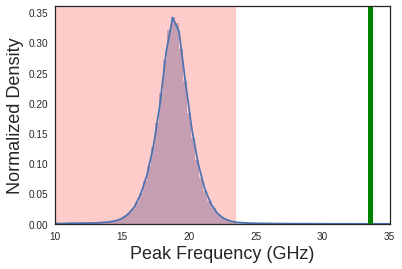

In [179]:
import matplotlib
with sb.axes_style("white"):
    fontsize = 18
    
    ame_freq_allsky = hp.read_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_var_FREQ_MEAN.fits')
    plt.figure()
    nuhist = sb.distplot(ame_freq_allsky[ame_freq_allsky!=hp.UNSEEN],
                rug=False, bins = 200 )

    nuhist.set_xlim(10,35)
    nuhist.set_xlabel("Peak Frequency (GHz)", fontsize=fontsize)
    nuhist.set_ylabel("Normalized Density", fontsize=fontsize)
    #nuhist.set_title("Per-pixel AME $\\nu_{peak}$ not well constrained", fontsize=fontsize)
    nuhist.axvline(x=33.5, ymin=0, ymax = 1, linewidth=5, color='g')

    nuhist.axvspan(8, 23.5, alpha=0.2, color='red')
    plt.savefig("../Plots/ch_intro/AME_commander_freqdist.pdf")


In [5]:
ame_hdu = fits.open('../Data/raw/COM_CompMap_AME-commander_0256_R2.00.fits.gz')
ame_hdu.info()
spdust_temp = pd.DataFrame(ame_hdu[3].data)
spdust_temp.head()
ame_hdu[3].header['BITPIX']

Filename: ../Data/raw/COM_CompMap_AME-commander_0256_R2.00.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  COMP-MAP-AME1    1 BinTableHDU     75   786432R x 6C   [E, E, E, E, E, E]   
  2  COMP-MAP-AME2    1 BinTableHDU     64   786432R x 3C   [E, E, E]   
  3  SPINNING-DUST-TEMP    1 BinTableHDU     62   1000R x 2C   [D, D]   


8

<bound method AxesSubplot.set_xticks of <matplotlib.axes._subplots.AxesSubplot object at 0x2b5963c5f6d0>>

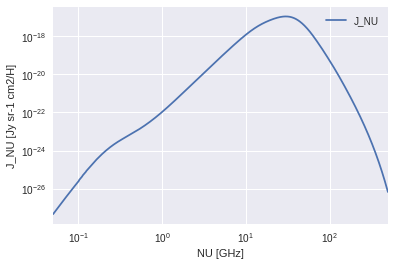

In [6]:
p = spdust_temp.plot(x='NU', 
                     y='J_NU')
p.set_xlabel("{} [{}]".format(ame_hdu[3].header['TTYPE1'],ame_hdu[3].header['TUNIT1']))
p.set_ylabel("{} [{}]".format(ame_hdu[3].header['TTYPE2'],ame_hdu[3].header['TUNIT2']))
p.set_xscale('log')
p.set_yscale('log')
p.set_xticks




# Reproduce Figure 4 (Spinning dust)
from Planck Collaboration: Diffuse component separation: Foreground maps

Brightness temperature for spinning dust emission at a given frequency is defined as follows (see. Table 4, PC2015X): 

$s_{sd} = A_{sd} * (\frac{\nu_0}{\nu})^2$

Keeping in mind that $f_{sd}$ is not an analytical function. It's a table of $J(\\nu)$ values copied from Haimoud+ (2011), and has environmental physics and grain assumptions already baked-in. The COMMANDER modeling, like the WMAP modeling before it, doesn't parametrize these assumptions- they just morph the function by applying a frequency shift factor. Although the spinning dust model `spdust` takes gas density, temperature, grain dipole moment, geometry, and axes of rotation as parameters, the COMMANDER fitting simplifies the problem to 2 parameters: effective peak frequency (after the shift from the 30 GHz peak, found in the assumed template) and a brightness temperature at an arbitrary "reference frequency."$

This approach however resulted in dust-correlated residuals. They compoensate by adding a second spatially constant spdust component. Their fits converged on 33.5 GHz for the peak of this component. 

We would like to note here that this results in one spdust component with a peak within the Planck-WMAP convered frequemcy ramge, and another (the spatially varying frequency component)that is typically below the shortest WMAP band. Thus the issue must be revisited when new low-frequency data becomes available. We consider this AME frequency map to be sufficient for the moment, but as the PC themselves warn in the COMMANDER paper, we have to be extrememly cautious in the physical interpretation of comparisons with this map.

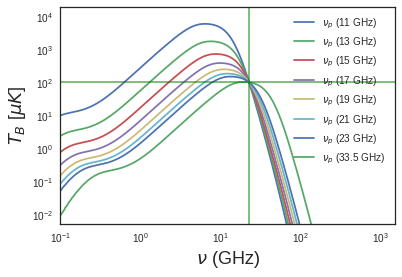

In [7]:


ame_hdu = fits.open('../Data/raw/COM_CompMap_AME-commander_0256_R2.00.fits.gz')
spdust_temp = pd.DataFrame(ame_hdu[3].data)

def getShiftedFsd( 
          f_sd,         # spdust template spectrum
          A_sd = 100.0, # brightness temp in uK
          nu_p  = 20.0, # desired peak temperature
          nu_0  = 22.8, # freq. at which COMMANDER map temp was quoted
          nu_p0 = 30.0  # peak freq. of the original spdust template
        ):
    
    nu_trans_fact = (nu_0/f_sd.NU)**2
    
    temp_trans_fact = (np.interp((f_sd.NU*nu_p0)/nu_p,f_sd.NU, f_sd.J_NU ) / \
                  np.interp((nu_0*nu_p0)/nu_p,f_sd.NU, f_sd.J_NU ))
    
    f_sd_shifted = A_sd * nu_trans_fact * temp_trans_fact
    
    
    return f_sd_shifted



spdust_temp["$\\nu_p$ (11 GHz)"] = getShiftedFsd(
                        f_sd = spdust_temp.copy(),
                        nu_p = 11.0)

spdust_temp['$\\nu_{p}$ (13 GHz)'] = getShiftedFsd(
                        f_sd = spdust_temp.copy(),
                        nu_p = 13.0)

spdust_temp['$\\nu_{p}$ (15 GHz)'] = getShiftedFsd(
                        f_sd = spdust_temp.copy(),
                        nu_p = 15.0)

spdust_temp['$\\nu_{p}$ (17 GHz)'] = getShiftedFsd(
                        f_sd = spdust_temp.copy(),
                        nu_p = 17.0)

spdust_temp['$\\nu_{p}$ (19 GHz)'] = getShiftedFsd(
                        f_sd = spdust_temp.copy(),
                        nu_p = 19.0)

spdust_temp['$\\nu_{p}$ (21 GHz)'] = getShiftedFsd(
                        f_sd = spdust_temp.copy(),
                        nu_p = 21.0)

spdust_temp['$\\nu_{p}$ (23 GHz)'] = getShiftedFsd(
                        f_sd = spdust_temp.copy(),
                        nu_p = 23.0)

spdust_temp['$\\nu_{p}$ (33.5 GHz)'] = getShiftedFsd(
                        f_sd = spdust_temp.copy(),
                        nu_p = 33.5)

#spdust_temp['$\\nu_{p}$ (30 GHz)'] = getShiftedFsd(
#                        f_sd = spdust_temp.copy(),
#                        nu_p = 30.0)

with sb.axes_style("white"):
    
    fontsize = 18
    plt.figure()
    p = spdust_temp.drop(['J_NU'], axis=1).plot(x='NU')

    #p.set_xlabel("{} [{}]".format(ame_hdu[3].header['TTYPE1'],ame_hdu[3].header['TUNIT1']))
    p.set_ylabel("$T_{B}$ [$\mu{}K$]", fontsize=fontsize)
    p.set_xlabel("$\\nu$ (GHz)", fontsize=fontsize)
    p.set_xscale('log')
    p.set_yscale('log')
    p.set_ylim((5e-3,2e4))
    p.set_xlim((1e-1,1.5e3))
    p.axvline(x=22.8, ymin=0, ymax = 1, linewidth=2, color='g', alpha=0.5)
    p.axhline(y=100, xmin=0, xmax = 1, linewidth=2, color='g', alpha=0.5)
    #plt.plot(sync_freq, sync_int*1e19, label = "Synchrotron")
    #plt.title("Frequency-Shifted spdust Templates", fontsize=fontsize)
    plt.savefig("../Plots/ch_datasources/AME_commander_freqshift_templ.pdf")
    plt.show()

# Numerically itnegrate the shifted  curves to get numerical intensity

A detail not fully addressed in other works, Hensley+ (2016), PC.., is that the COMMANDER map is given in brightness temperature at a reference frequency. This is useful for quickly assesing the relative contribution of intensity in Planck, WMAP bands at 22.8GHZ and 41GHZ Hensley+ (2016). It is a bit less physically intuitive however, when attempting to interpret the AME itself. Hensley+ (2016) calculated the brightness temperature for each component, at a common 30 GHz reference frequency, allowing the total brightness of AME (combinging spatially fixed and varying components) to be evaluated. We consider this to be a good approximation, but would also like to take it a step further. The available commander parameters allow us to obtain a somewhat more robust metric of AME, by integrating the fitted spinning dust functions, and combing the two components. This would be a quantity more analagous to the radiance of thermal dust. 

In [6]:
spdust_temp.head()

NU          J_NU  $\nu_p$ (11 GHz)  $\nu_{p}$ (21 GHz)  \
0  0.050231  4.609770e-28          2.294688            0.007111   
1  0.050696  4.865184e-28          2.405315            0.007358   
2  0.051165  5.134620e-28          2.472371            0.007613   
3  0.051638  5.418841e-28          2.537264            0.007876   
4  0.052116  5.718646e-28          2.603476            0.008148   

   $\nu_{p}$ (31 GHz)  
0            0.001136  
1            0.001115  
2            0.001095  
3            0.001075  
4            0.001081

### Actual integration:
We'll use trapazoidal numerical integration, enabled by the `numpy.trapz` function.


In [8]:
spdust_int_21 = np.trapz(y = abs(np.log(spdust_temp['$\\nu_{p}$ (21 GHz)'])),
                         x = np.log(spdust_temp['NU']), 
                         axis=0)
print spdust_int_21
print (np.log(spdust_temp['$\\nu_{p}$ (21 GHz)'].max()+abs(np.log(spdust_temp['$\\nu_{p}$ (21 GHz)'].min()))) * np.log(500))

45.0941952506
33.1333751783


In [9]:
def getIntegral(nu_peak, t_peak, f_sd, fix=False):
    
    if fix==True:
        nu_ref = 41.0
    else: 
        nu_ref = 28.5
    
    f_sd_shifted = getShiftedFsd( 
          f_sd, 
          A_sd = t_peak, # uK
          nu_p  = nu_peak, # GHz
          nu_0  = nu_ref, # From PR2 AME map
          nu_p0 = 30.0 # From spdust templ.
        )
    
    integral = np.trapz(y = f_sd_shifted,
                        x = f_sd.NU, 
                         axis=0)
    return integral

print getIntegral(29, 10000, spdust_temp)

377523.709646


In [10]:
def getPeakTemp(nu_peak, t_peak, f_sd, fix=False):
    
    if fix==True:
        nu_ref = 41.0
    else: 
        nu_ref = 28.5
    
    f_sd_shifted = getShiftedFsd( 
          f_sd, 
          A_sd = t_peak, # uK
          nu_p  = nu_peak, # GHz
          nu_0  = nu_ref, # From PR2 AME map
          nu_p0 = 30.0 # From spdust templ.
        )
    
    peaktemp = np.interp(nu_peak, 
                         f_sd.NU, 
                         f_sd_shifted )
    
    return peaktemp

print getPeakTemp(15, 100, spdust_temp)

2023.0068593


In [9]:
LOri_ame1_freq = fits.getdata('/work1/users/aaronb/Codebrary/latex/CosmicDust/Data/LOri_AME1_freq.fits')
LOri_ame1_I    = fits.getdata('/work1/users/aaronb/Codebrary/latex/CosmicDust/Data/LOri_AME1_I_256.fits')
LOri_ame2_I    = fits.getdata('/work1/users/aaronb/Codebrary/latex/CosmicDust/Data/LOri_AME2_I_256.fits')
nu_fix = 33.5
nu_fix_ref = 41.0
LOri_ame1_rad  = np.array([getIntegral(LOri_ame1_freq.flatten()[i], LOri_ame1_I.flatten()[i], spdust_temp) for i in range(0,2500)])
LOri_ame2_rad  = np.array([getIntegral(nu_fix, LOri_ame1_I.flatten()[i], spdust_temp, fix=True) for i in range(0,2500)])



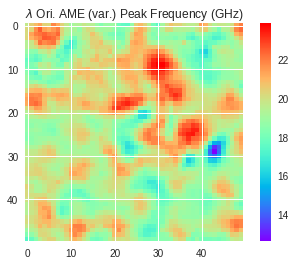

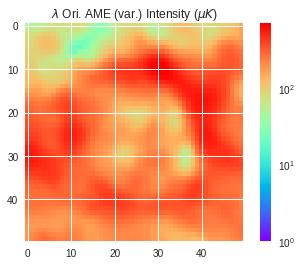

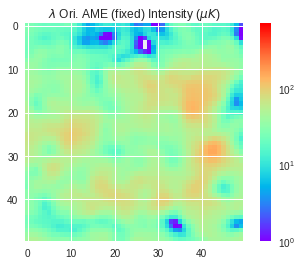

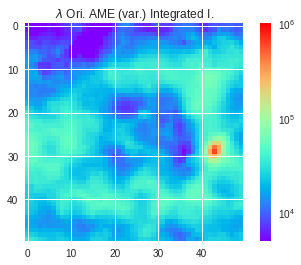

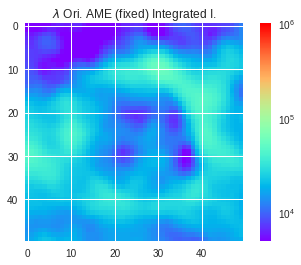

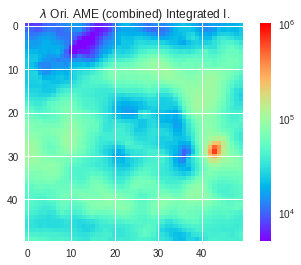

In [10]:
cmap = "rainbow"
from matplotlib.colors import LogNorm

norm = LogNorm()
plt.imshow(LOri_ame1_freq, cmap=cmap)
plt.title("$\lambda$ Ori. AME (var.) Peak Frequency (GHz)")
plt.colorbar()
plt.savefig("../Plots/LOri/AME1_freq.pdf")
plt.show()

plt.imshow(LOri_ame1_I, cmap=cmap, vmin = 1, vmax=700, norm=norm)
plt.title("$\lambda$ Ori. AME (var.) Intensity ($\mu{}K$)")
plt.colorbar()
plt.savefig("../Plots/LOri/AME1_temp.pdf")
plt.show()

plt.imshow(LOri_ame2_I, cmap=cmap,  vmin = 1, vmax=700, norm=norm)
plt.title("$\lambda$ Ori. AME (fixed) Intensity ($\mu{}K$)")
plt.colorbar()
plt.savefig("../Plots/LOri/AME2_temp.pdf")
plt.show()

plt.imshow(LOri_ame1_rad.reshape(50,50), cmap=cmap,  vmin = 5e3, vmax=1e6, norm=norm)
plt.title("$\lambda$ Ori. AME (var.) Integrated I.")
plt.colorbar()
plt.savefig("../Plots/LOri/AME1_rad.pdf")
plt.show()

plt.imshow(LOri_ame2_rad.reshape(50,50), cmap=cmap,  vmin = 5e3, vmax=1e6, norm=norm)
plt.title("$\lambda$ Ori. AME (fixed) Integrated I.")
plt.colorbar()
plt.savefig("../Plots/LOri/AME2_rad.pdf")
plt.show()

ame_combined_rad = (LOri_ame2_rad+LOri_ame1_rad).reshape(50,50)

plt.imshow(ame_combined_rad, cmap=cmap,  vmin = 5e3, vmax=1e6, norm=norm)
plt.title("$\lambda$ Ori. AME (combined) Integrated I.")
plt.colorbar()
plt.savefig("../Plots/LOri/AMEcombined_rad.pdf")
plt.show()

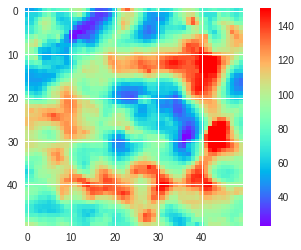

/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


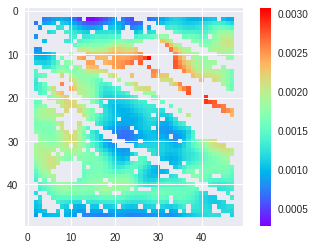

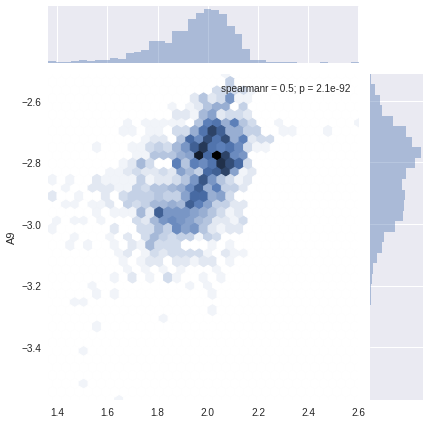

In [90]:
PR2_Idust = fits.getdata('/work1/users/aaronb/Codebrary/latex/CosmicDust/Data/LOri_PR2_Idust.fits').flatten()

ame_combined_dust_rad_ratio = ame_combined_rad / PR2_Idust.reshape((50,50))

plt.imshow(
    ame_combined_dust_rad_ratio, 
    cmap=cmap,
    vmax=150)

plt.colorbar()
plt.show()
#plt.hist(ame_combined_dust_rad_ratio, xrange=(50,200))
#plt.show()

A9_dust_rad_ratio = lori_df['A9'] / PR2_Idust#.reshape((50,50))

plt.imshow(
    A9_dust_rad_ratio.reshape((50,50)), 
    cmap=cmap)

plt.colorbar()
plt.show()


sb.jointplot(np.log10(ame_combined_dust_rad_ratio.flatten()), 
             np.log10(A9_dust_rad_ratio), 
             stat_func = spearmanr,
            kind = 'hex')

In [12]:
lori_df = pd.DataFrame()
lori_df_mask = pd.DataFrame()
lori_df['A9']  = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_9_256.fits').flatten()
lori_df['D12']  = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_dirbe_12_256.fits').flatten()
lori_df['I12']  = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_iras_12_256.fits').flatten()
lori_df['A18'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_18_256.fits').flatten()
lori_df['D25']  = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_dirbe_25_256.fits').flatten()
lori_df['I25']  = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_iras_25_256.fits').flatten()
lori_df['D60'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_dirbe_60_256.fits').flatten()
lori_df['A65'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_65_256.fits').flatten()
lori_df['A90'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_90_256.fits').flatten()
lori_df['A140'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_140_256.fits').flatten()
lori_df['A160'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_160_256.fits').flatten()
lori_df['P857'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_planck_857_256.fits').flatten()
lori_df['P545'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_planck_545_256.fits').flatten()
lori_df['AME'] = fits.getdata('/work1/users/aaronb/Codebrary/latex/CosmicDust/Data/LOri_AME1_I_256.fits').flatten()
lori_df_mask['mask'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_256_mask.fits').flatten()


lori_df_mask['mask'][lori_df['D12']>=1.3] = np.nan

for i in range(0, len(lori_df_mask['mask']) ):
    
    if np.isnan(lori_df_mask['mask'].iloc[i]):
    
        #print 'NaNpix at {}'.format(i)
        lori_df.iloc[i] = np.nan
        

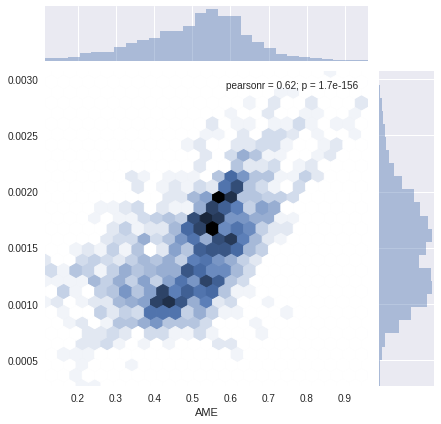

In [13]:
sb.jointplot(lori_df['AME']/PR2_Idust, lori_df.A9.values.flatten()/PR2_Idust , kind= "hex")

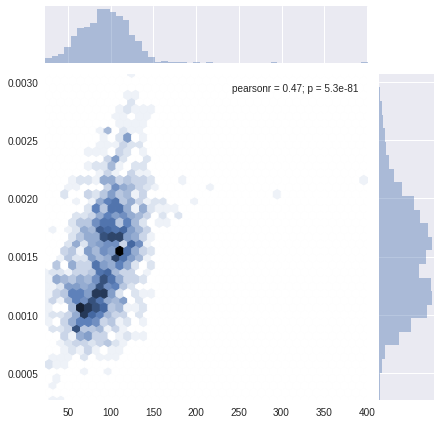

In [14]:
# Integrated AME intensity / Dust Radiance vs. IRC 9 micron intensity / Dust Radiance
sb.jointplot(ame_combined_dust_rad_ratio.flatten(), 
             lori_df.A9.values.flatten()/PR2_Idust, kind = "hex" )

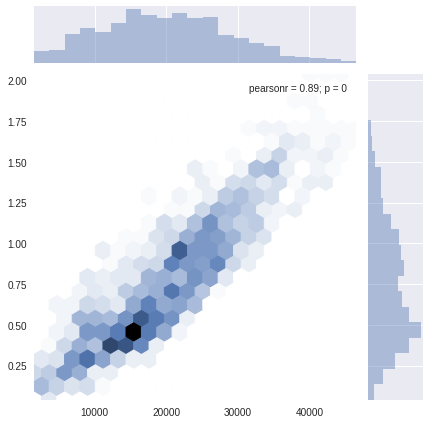

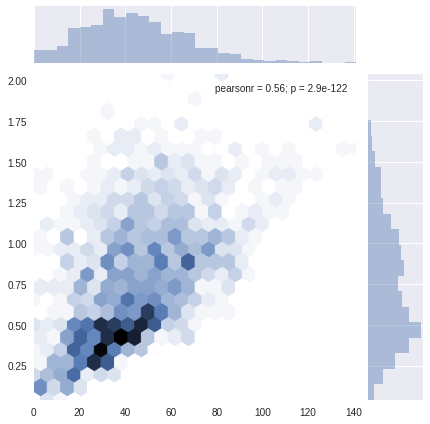

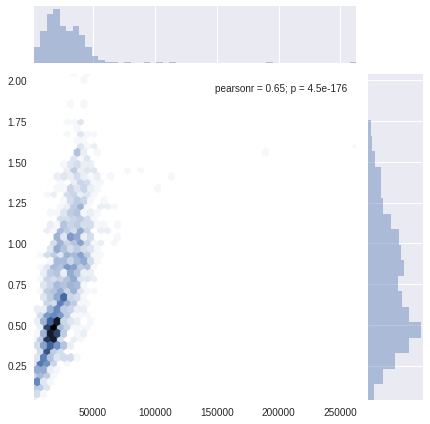

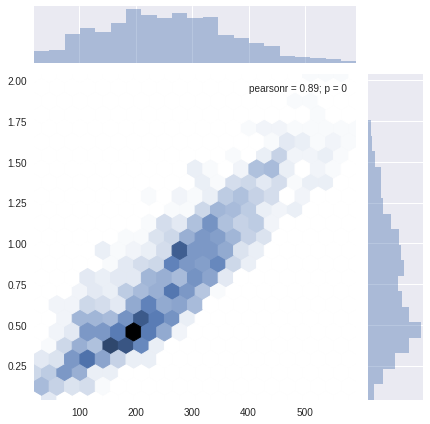

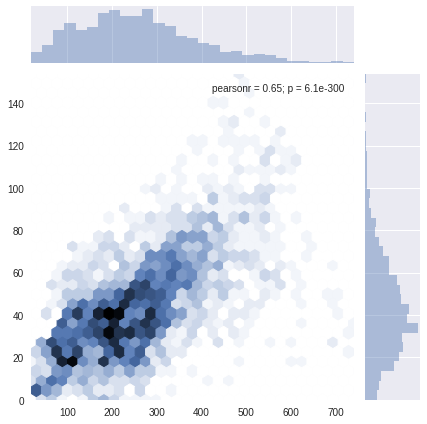

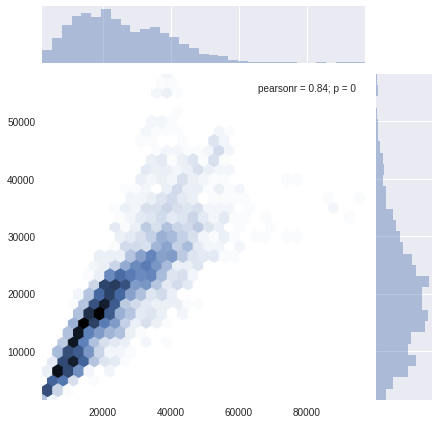

In [15]:
# Integrated AME intensity / Dust Radiance vs. IRC 9 micron intensity / Dust Radiance
sb.jointplot(LOri_ame2_rad.flatten(), 
             lori_df.A9.values.flatten(), kind = "hex" )

sb.jointplot(LOri_ame2_I.flatten(), 
             lori_df.A9.values.flatten(), kind = "hex" )

sb.jointplot(LOri_ame1_rad.flatten(), 
             lori_df.A9.values.flatten(), kind = "hex" )

sb.jointplot(LOri_ame1_I.flatten(), 
             lori_df.A9.values.flatten(), kind = "hex" )

sb.jointplot(LOri_ame1_I.flatten(), 
             LOri_ame2_I.flatten(), kind = "hex" )

sb.jointplot(LOri_ame1_rad.flatten()[LOri_ame1_rad.flatten()<1e5], 
             LOri_ame2_rad.flatten()[LOri_ame1_rad.flatten()<1e5], kind = "hex" )

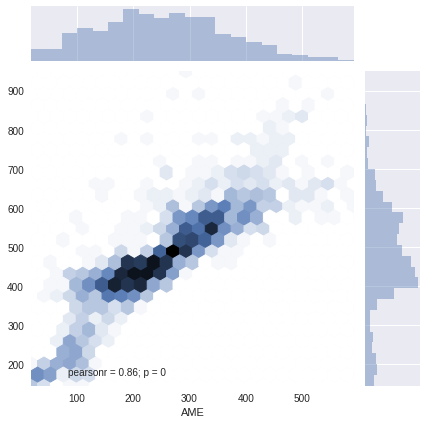

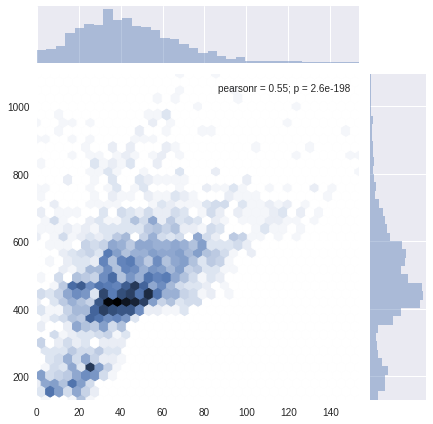

In [16]:
sb.jointplot(lori_df['AME'], 
             PR2_Idust , 
             kind= "hex")

sb.jointplot(LOri_ame2_I.flatten(), 
             PR2_Idust , 
             kind= "hex")

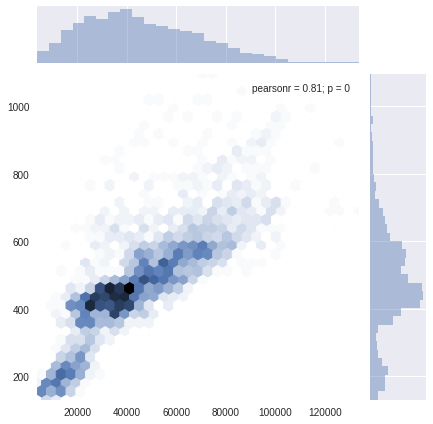

In [17]:
sb.jointplot(
    (LOri_ame1_rad+LOri_ame2_rad).flatten()[LOri_ame1_rad.flatten()<1e5], 
             PR2_Idust[LOri_ame1_rad.flatten()<1e5] , 
             kind= "hex")

In [18]:
#sb.jointplot(lori_df['AME'], ame1_I , kind= "hex")

NameError: name 'ame1_I' is not defined

In [ ]:
#sb.jointplot(ame_combined_dust_rad_ratio.flatten(), lori_df.A9.values.flatten()/PR2_Idust , kind= "hex")

In [ ]:
#sb.jointplot(ame_combined_dust_rad_ratio.flatten(), lori_df.A18.values.flatten()/PR2_Idust , kind= "hex")

In [ ]:
#ame1_I = fits.getdata('/work1/users/aaronb/Codebrary/latex/CosmicDust/Data/LOri_AME1_I_256.fits').flatten()

In [ ]:
#ame_rad_ratio = ame1_I / PR2_Idust
#ame_rad_diff = ame1_I - PR2_Idust

In [ ]:
#sb.jointplot(ame_rad_ratio.flatten(), lori_df.A9.values.flatten()/PR2_Idust , kind= "hex")

In [ ]:
# Make frequency corrected all-sky maps

In [19]:
ame1_freq_allsky = hp.read_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_var_FREQ_MEAN.fits', nest=True)
ame1_temp_allsky = hp.read_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_var_I_MEAN.fits', nest=True)
ame2_temp_allsky = hp.read_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_fix_I_MEAN.fits', nest=True)

nu_fix = 33.5

# ame1_rad_allsky  = np.array(
#     [
#         getIntegral(
#             ame1_freq_allsky[i], 
#             ame1_temp_allsky[i], 
#             spdust_temp, 
#             fix=True) for i in range(0,hp.nside2npix(256))
#     ]
# )

# print "AME1 finished"

# ame2_rad_allsky  = np.array(
#     [
#         getIntegral(
#             nu_fix, 
#             ame2_temp_allsky[i], 
#             spdust_temp, 
#             fix=True) for i in range(0,hp.nside2npix(256))
#     ]
# )


ame1_pktemp_allsky  = np.array(
#     [
#         getIntegral(
#             ame1_freq_allsky[i], 
#             ame1_temp_allsky[i], 
#             spdust_temp, 
#             fix=True) for i in range(0,hp.nside2npix(256))
#     ]
# )


NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Ordering converted to NEST
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Ordering converted to NEST
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Ordering converted to NEST


In [20]:
# hp.write_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_var_INT_I.fits', 
#              ame1_rad_allsky,
#              nest=True,
#             coord='G',
#             overwrite=True)

# hp.write_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_fix_INT_I.fits', 
#              ame2_rad_allsky,
#              nest=True,
#             coord='G',
#             overwrite=True)



In [59]:
# #Make peak frequency maps:
# ame1_Ipeak_allsky  = np.array(
#     [
#         getPeakTemp(
#             ame1_freq_allsky[i], 
#             ame1_temp_allsky[i], 
#             spdust_temp, 
#             fix=True) for i in range(0,hp.nside2npix(256))
#     ]
# )

In [ ]:
# hp.write_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_var_PEAK_I.fits', 
#               ame1_Ipeak_allsky,
#               nest=True,
#               coord='G',
#               overwrite=True)

In [177]:
# #Make peak frequency maps:
# npix = hp.nside2npix(256)

# ame2_Ipeak_allsky  = np.array(
#     [
#         getPeakTemp(
#             33.5, 
#             ame2_temp_allsky[i], 
#             spdust_temp, 
#             fix=True) for i in range(0,npix)
#     ]
# )

In [178]:
# hp.write_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_fix_PEAK_I.fits', 
#               ame2_Ipeak_allsky,
#               nest=True,
#               coord='G',
#               overwrite=True)

In [21]:
# ame1_rad_allsky = hp.read_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_var_INT_I.fits', nest=True)
# ame2_rad_allsky = hp.read_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_fix_INT_I.fits', nest=True)

# hp.write_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_comb_INT_I.fits', 
#               ame1_rad_allsky + ame2_rad_allsky,
#               nest=True,
#               coord='G',
#               overwrite=True)

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


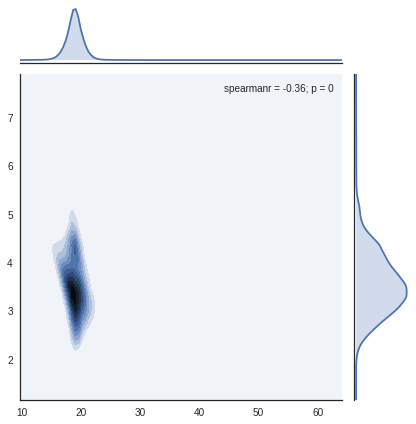

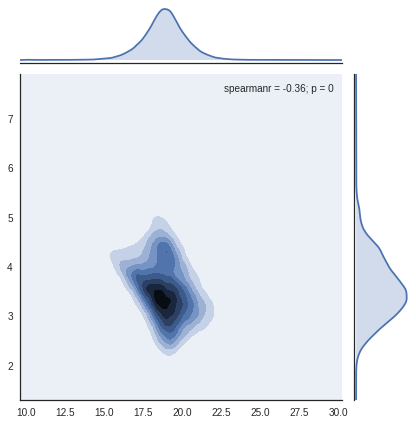

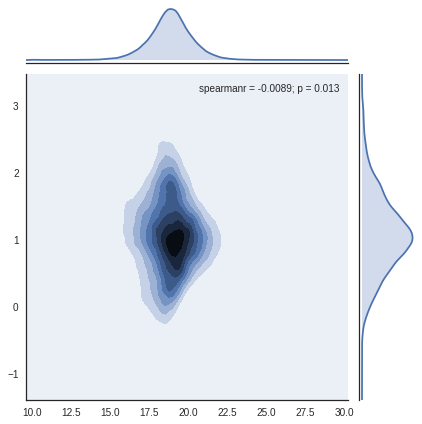

In [92]:
from scipy.stats import spearmanr

def plt_AMEvar_freq(x, 
                    y, 
                    stat_func=spearmanr, 
                    kind='reg'):
    
    with sb.axes_style("white"):
        sb.jointplot(x, 
                     np.log10(y),
                     stat_func = stat_func,
                     kind = kind)
    
plt_AMEvar_freq(ame1_freq_allsky[::10],
                ame1_Ipeak_allsky[::10],
               kind = 'kde')

plt_AMEvar_freq(ame1_freq_allsky[::10][ame1_freq_allsky[::10]<30],
                ame1_Ipeak_allsky[::10][ame1_freq_allsky[::10]<30],
               kind = 'kde')

plt_AMEvar_freq(ame1_freq_allsky[::10][ame1_freq_allsky[::10]<30],
                ame2_temp_allsky[::10][ame1_freq_allsky[::10]<30],
               kind = 'kde')


In [ ]:
with sb.axes_style("white"):   
    
    sb.distplot(
        np.log(ame1_rad_allsky), 
        bins=100)
    
    sb.distplot(
        np.log(ame2_rad_allsky),
        bins=100)
    
    plt.show()


    sb.distplot(
        np.log(ame1_temp_allsky),
        bins=100)
    
    sb.distplot(
        np.log(ame2_temp_allsky), 
        bins=100)

In [ ]:
sb.jointplot(np.log(
                ame1_rad_allsky[::10][ame_freq_allsky[::10]<30]), 
                ame_freq_allsky[::10][ame_freq_allsky[::10]<30],
               kind = "hex")

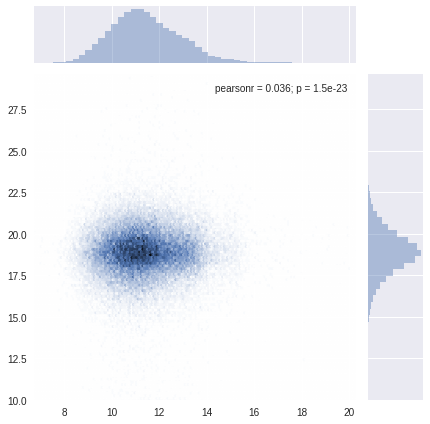

In [26]:
sb.jointplot(np.log(
                ame1_rad_allsky[::10][ame_freq_allsky[::10]<30]), 
                ame_freq_allsky[::10][ame_freq_allsky[::10]<30],
               kind = "hex")

In [ ]:
sb.jointplot(np.log(
                ame2_rad_allsky[::10][ame_freq_allsky[::10]<30]), 
                ame_freq_allsky[::10][ame_freq_allsky[::10]<30],
               kind = "hex")

# Demonstrate Discrepancy between AME "Reference Intensity" and Integrated Intensity

In [ ]:
sb.jointplot(np.log(
                ame1_rad_allsky[::10], 
             np.log(
                 ame1_temp_allsky[::10]),
               kind = "hex")

sb.jointplot(ame1_rad_allsky[::10], 
             ame1_temp_allsky[::10],
               kind = "hex")

In [ ]:
sb.regplot(ame1_rad_allsky, 
           ame1_freq_allsky/1e8 )

In [ ]:
sb.jointplot(ame1_rad_allsky, 
             ame1_freq_allsky, kind = "hex" )

In [ ]:
hp.mollview(ame2_rad_allsky, norm='log',cmap="rainbow", nest=True)

In [ ]:
hp.mollview(ame1_rad_allsky-ame2_rad_allsky, norm='symlog', nest=True, cmap="rainbow")

In [ ]:
hp.mollview(ame1_rad_allsky+ame2_rad_allsky, norm='log', nest=True, cmap="rainbow")

In [3]:
sync_hdu = fits.open('../Data/raw/COM_CompMap_Synchrotron-commander_0256_R2.00.fits.gz')
sync_hdu.info()
#syn_temp = pd.DataFrame(ame_hdu[3].data)
#spdust_temp.head()
#ame_hdu[3].header['BITPIX']

sync_template_1 = sync_hdu[2].data
sync_template_1

#sync_template_2 = sync_hdu[2][0].data

#plt.scatter(sync_template_1)


Filename: ../Data/raw/COM_CompMap_Synchrotron-commander_0256_R2.00.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  COMP-MAP-Synchrotron    1 BinTableHDU     64   786432R x 3C   [E, E, E]   
  2  SYNC-TEMP     1 BinTableHDU     50   78R x 2C   [D, D]   


FITS_rec([(  1.00000000e-03,   4.01936000e-19),
          (  1.20000000e-03,   5.84252000e-19),
          (  1.44000000e-03,   8.32459000e-19),
          (  1.72800000e-03,   1.16580000e-18),
          (  2.07360000e-03,   1.60901000e-18),
          (  2.48832000e-03,   2.19837000e-18),
          (  2.98598400e-03,   2.99846000e-18),
          (  3.58318080e-03,   4.13791000e-18),
          (  4.29981700e-03,   5.80208000e-18),
          (  5.15978040e-03,   8.05537000e-18),
          (  6.19173640e-03,   1.06483000e-17),
          (  7.43008370e-03,   1.31103000e-17),
          (  8.91610040e-03,   1.50249000e-17),
          (  1.06993210e-02,   1.61953000e-17),
          (  1.28391850e-02,   1.66342000e-17),
          (  1.54070220e-02,   1.64726000e-17),
          (  1.84884260e-02,   1.58760000e-17),
          (  2.21861110e-02,   1.49961000e-17),
          (  2.66233330e-02,   1.39533000e-17),
          (  3.19480000e-02,   1.28348000e-17),
          (  3.83376000e-02,   1.1700300

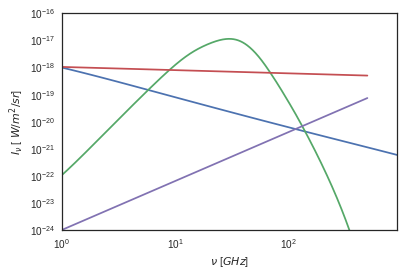

In [13]:
#sync_template = np.ones((2, np.size(sync_template_1)))
#print np.shape(sync_template)
plt.close()
sync_freq = np.array([sync_template_1[i][0] for i in range(0,np.size(sync_template_1))])
                            
sync_int = np.array([sync_template_1[i][1] for i in range(0,np.size(sync_template_1))])
with sb.axes_style("white"):

    plt.plot(sync_freq,
               sync_int, label = "Synchrotron")


    f_sd = spdust_temp.copy()
    plt.plot(f_sd.NU , f_sd.J_NU, label = "Spinning dust")
    #plt.plot(f_sd.NU, f_sd.NU**(-0.118))
    plt.plot(f_sd.NU, (f_sd.NU**(-0.118))*1e-18, label="free-free")
    #plt.plot(f_sd.NU, (f_sd.NU**(1.6))*1e-24)
    plt.plot(f_sd.NU, (f_sd.NU**(1.8))*1e-24, label = "Thermal dust")
    plt.xscale('log')
    plt.yscale('log')
  
    plt.xlabel('$\\nu$ [$GHz$]')
    plt.ylabel('$I_{\\nu}$ [ $W/m^{2}/sr$]')
        
    plt.xlim(1e0, 0.9e3)
    plt.ylim(1e-24,1e-16)

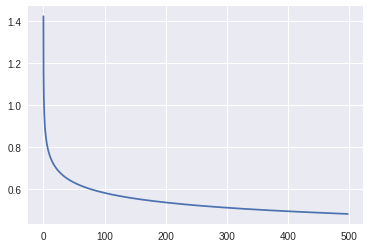

In [14]:
plt.plot(f_sd.NU, f_sd.NU**(-0.118))

In [15]:
(f_sd.NU**(-0.118))*1e-18

0      1.423264e-18
1      1.421718e-18
2      1.420174e-18
3      1.418631e-18
4      1.417090e-18
5      1.415551e-18
6      1.414013e-18
7      1.412478e-18
8      1.410943e-18
9      1.409411e-18
10     1.407880e-18
11     1.406350e-18
12     1.404823e-18
13     1.403297e-18
14     1.401773e-18
15     1.400250e-18
16     1.398729e-18
17     1.397210e-18
18     1.395692e-18
19     1.394176e-18
20     1.392661e-18
21     1.391149e-18
22     1.389638e-18
23     1.388128e-18
24     1.386620e-18
25     1.385114e-18
26     1.383610e-18
27     1.382107e-18
28     1.380605e-18
29     1.379106e-18
           ...     
970    4.959587e-19
971    4.954200e-19
972    4.948819e-19
973    4.943443e-19
974    4.938073e-19
975    4.932710e-19
976    4.927351e-19
977    4.921999e-19
978    4.916653e-19
979    4.911312e-19
980    4.905977e-19
981    4.900648e-19
982    4.895325e-19
983    4.890008e-19
984    4.884696e-19
985    4.879390e-19
986    4.874090e-19
987    4.868796e-19
988    4.863507e-19


# Free free emission:
Sc22kT2âˆ’01

In [16]:
np.size(sync_template_1)

78

In [17]:
wmap_K = hp.read_map('../Data/raw/WMAP/wmap_band_imap_r9_5yr_K_v3.fits')

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/healpy/fitsfunc.py:326: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/healpy/projaxes.py:859: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  result[np.isinf(val.data)] = -np.inf


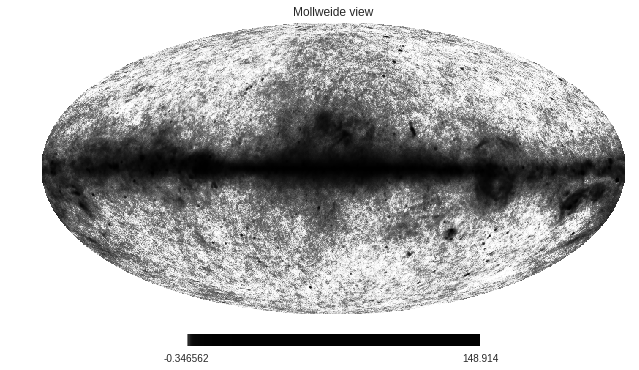

In [18]:
hp.mollview(wmap_K, 
            norm='hist')

Microwave Band	K	Ka	Q	V	W  
Frequency (GHz)	22	30	40	60	90  
Wavelength (mm)	13.6	10.0	7.5	5.0	3.3  


In [19]:
wmaplist = ['K','Ka','Q','V','W']
wmapfreqlist = [23,33,41,61,94]

wmapframe = pd.DataFrame()

for i in range(0,len(wmaplist)):
    
    band = wmaplist[i]
    freq = wmapfreqlist[i]
    
    wmapfilen = '../Data/raw/WMAP/wmap_band_imap_r9_5yr_{}_v3.fits'.format(band)

    
    map512 = hp.read_map(wmapfilen
                         , nest=True)
    
    map256 = hp.ud_grade(map512, 
                      nside_out = 256, 
                      order_in = 'NESTED', 
                      order_out = 'NESTED',
                      pess=True)
    
    wmapframe[freq] = map256

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


In [20]:
wmapframe.head()

23        33        41        61        94
0  15.962852  7.259521  4.660733  2.635867  2.179363
1  15.749136  7.404387  4.637368  2.278363  1.733812
2  13.798688  5.784828  3.249224  1.477746  1.443560
3  12.817447  5.357659  2.964100  1.321413  1.248058
4  13.944617  6.068353  3.573342  1.512267  1.399581

In [21]:
import os
planckpcadir = '/work1/users/aaronb/Codebrary/Python/Projects/PlanckPCA/data/planck'
maplist = os.listdir(planckpcadir)

mapframe = pd.DataFrame()
planckfreqlist = [100,143,217,353,545,857,30,44,70]
for i in range(0,len(maplist)):
    map = maplist[i]
    freq = planckfreqlist[i]
    mapframe[freq] = hp.ud_grade(hp.read_map(planckpcadir+"/"+map,nest=True), 
                                       nside_out = 256, 
                                       order_in = 'NESTED', 
                                       order_out = 'NESTED')

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


In [22]:
mapframe.head()

100       143       217       353         545         857       30   \
0  0.003830  0.004178  0.014782  0.103821  108.037699  365.824993  0.008855   
1  0.002438  0.002895  0.010162  0.075272   76.607884  246.848178  0.008559   
2  0.001810  0.002644  0.009379  0.070464   70.832552  224.532248  0.007743   
3  0.001516  0.002277  0.007935  0.059257   59.376557  185.035241  0.007101   
4  0.001664  0.002583  0.008860  0.066923   66.765757  208.564267  0.007682   

        44        70   
0  0.003170  0.001559  
1  0.003116  0.001533  
2  0.002752  0.001381  
3  0.002577  0.001300  
4  0.002804  0.001398

In [23]:
mwframe = (wmapframe/1000).join(mapframe)

In [24]:
mwframe.head()

23        33        41        61        94        100       143  \
0  0.015963  0.007260  0.004661  0.002636  0.002179  0.003830  0.004178   
1  0.015749  0.007404  0.004637  0.002278  0.001734  0.002438  0.002895   
2  0.013799  0.005785  0.003249  0.001478  0.001444  0.001810  0.002644   
3  0.012817  0.005358  0.002964  0.001321  0.001248  0.001516  0.002277   
4  0.013945  0.006068  0.003573  0.001512  0.001400  0.001664  0.002583   

        217       353         545         857       30        44        70   
0  0.014782  0.103821  108.037699  365.824993  0.008855  0.003170  0.001559  
1  0.010162  0.075272   76.607884  246.848178  0.008559  0.003116  0.001533  
2  0.009379  0.070464   70.832552  224.532248  0.007743  0.002752  0.001381  
3  0.007935  0.059257   59.376557  185.035241  0.007101  0.002577  0.001300  
4  0.008860  0.066923   66.765757  208.564267  0.007682  0.002804  0.001398

MJy/sr / K_CMB:
857 GHz = 2.27
545 GHz = 58.04

In [25]:
mwframe[857] /= 2.27

In [26]:
mwframe[545] /= 58.04

In [27]:
mwframe.head()

23        33        41        61        94        100       143  \
0  0.015963  0.007260  0.004661  0.002636  0.002179  0.003830  0.004178   
1  0.015749  0.007404  0.004637  0.002278  0.001734  0.002438  0.002895   
2  0.013799  0.005785  0.003249  0.001478  0.001444  0.001810  0.002644   
3  0.012817  0.005358  0.002964  0.001321  0.001248  0.001516  0.002277   
4  0.013945  0.006068  0.003573  0.001512  0.001400  0.001664  0.002583   

        217       353       545         857       30        44        70   
0  0.014782  0.103821  1.861435  161.156384  0.008855  0.003170  0.001559  
1  0.010162  0.075272  1.319915  108.743691  0.008559  0.003116  0.001533  
2  0.009379  0.070464  1.220409   98.912885  0.007743  0.002752  0.001381  
3  0.007935  0.059257  1.023028   81.513322  0.007101  0.002577  0.001300  
4  0.008860  0.066923  1.150340   91.878532  0.007682  0.002804  0.001398

In [28]:
mwframe.columns

Int64Index([23, 33, 41, 61, 94, 100, 143, 217, 353, 545, 857, 30, 44, 70], dtype='int64')

In [276]:
coords.glon.iloc[432794]

159.08203125

In [120]:
mwframe.columns.values

array([ 23,  33,  41,  61,  94, 100, 143, 217, 353, 545, 857,  30,  44,  70])

In [122]:
mwframe = mwframe[[ 23, 30, 33,  41, 44,  61, 70, 94, 100, 143, 217, 353, 545, 857]]

In [123]:
mwcorr = mwframe.corr(method='spearman')

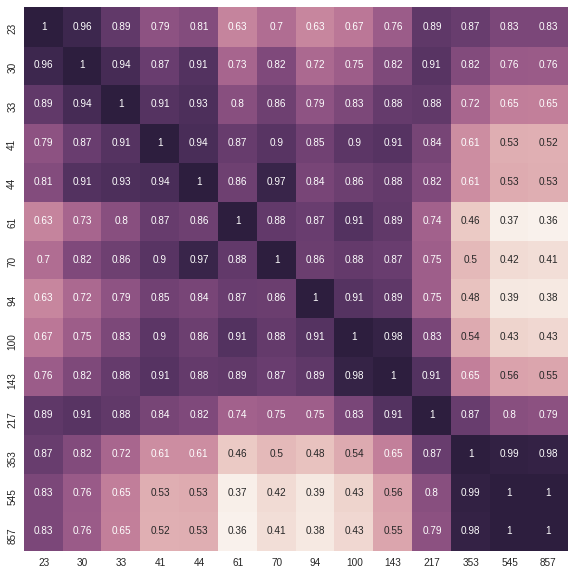

In [128]:
plt.figure(figsize=(10,10))
sb.heatmap(mwcorr, square=True, annot=True, cbar=False)

In [133]:
# Chapter 1:
### Data dimensionality
from sklearn.decomposition import PCA

def getPCA(X, n_components=12, whiten=False): # In principle, you can have as many components as input vectors
    
    X_ = X.dropna()
    # Principal component analysis
    pca = PCA(n_components=n_components, whiten=whiten)
    S_pca_ = pca.fit(X_).transform(X_)
  
    return S_pca_, pca

S_pca_, pca = getPCA(mwframe)

print pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1]+pca.explained_variance_ratio_[2]


0.999999998935


<Container object of 12 artists>

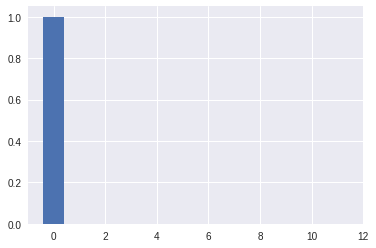

In [134]:
plt.bar(range(0,np.size(pca.explained_variance_ratio_)),
        pca.explained_variance_ratio_[:])

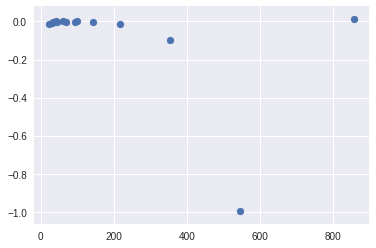

In [135]:
plt.scatter(mwframe.columns,pca.components_[1])

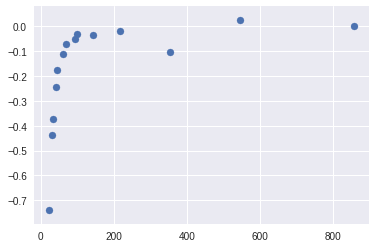

In [136]:
plt.scatter(mwframe.columns,pca.components_[2])

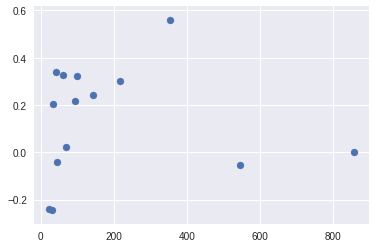

In [137]:
plt.scatter(mwframe.columns,pca.components_[3])